# Deep Reinforcement Learning for Trading Commodities
DRAGIC Marius & POULET Lancelin

## Imports

In [39]:
import yfinance as yf
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import gymnasium as gym
from gymnasium import spaces
from collections import deque
from stable_baselines3.common.vec_env import DummyVecEnv
import random
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.preprocessing import MinMaxScaler
from tqdm.notebook import tqdm
import copy

# Load data

In [40]:
# Commodities we choose to work on

# GC=F: Gold
# SI=F: Silver
# NG=F: Natural Gas
commodities = ['GC=F', 'SI=F', 'NG=F']

def get_commodities_data(tickers:list, start="2010-01-01", end="2023-01-01", interval="1d"):
    """Download commodities data from Yahoo Finance.

    Args:
        tickers (list): list of tickers
        start (str, optional): start date. Defaults to "2010-01-01".
        end (str, optional): end date. Defaults to "2023-01-01".
        interval (str, optional): frequency of data. Defaults to "1d".

    Returns:
        dict: dictionnary of the commodities wanted
    """
    data = {}
    for ticker in tickers:
        df = yf.download(ticker, start=start, end=end, interval=interval)
        # Flatten columns
        if isinstance(df.columns, pd.MultiIndex):
            df.columns = df.columns.get_level_values(0)
        data[ticker] = df
    return data

commodities_data = get_commodities_data(commodities)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


## Data Visualization

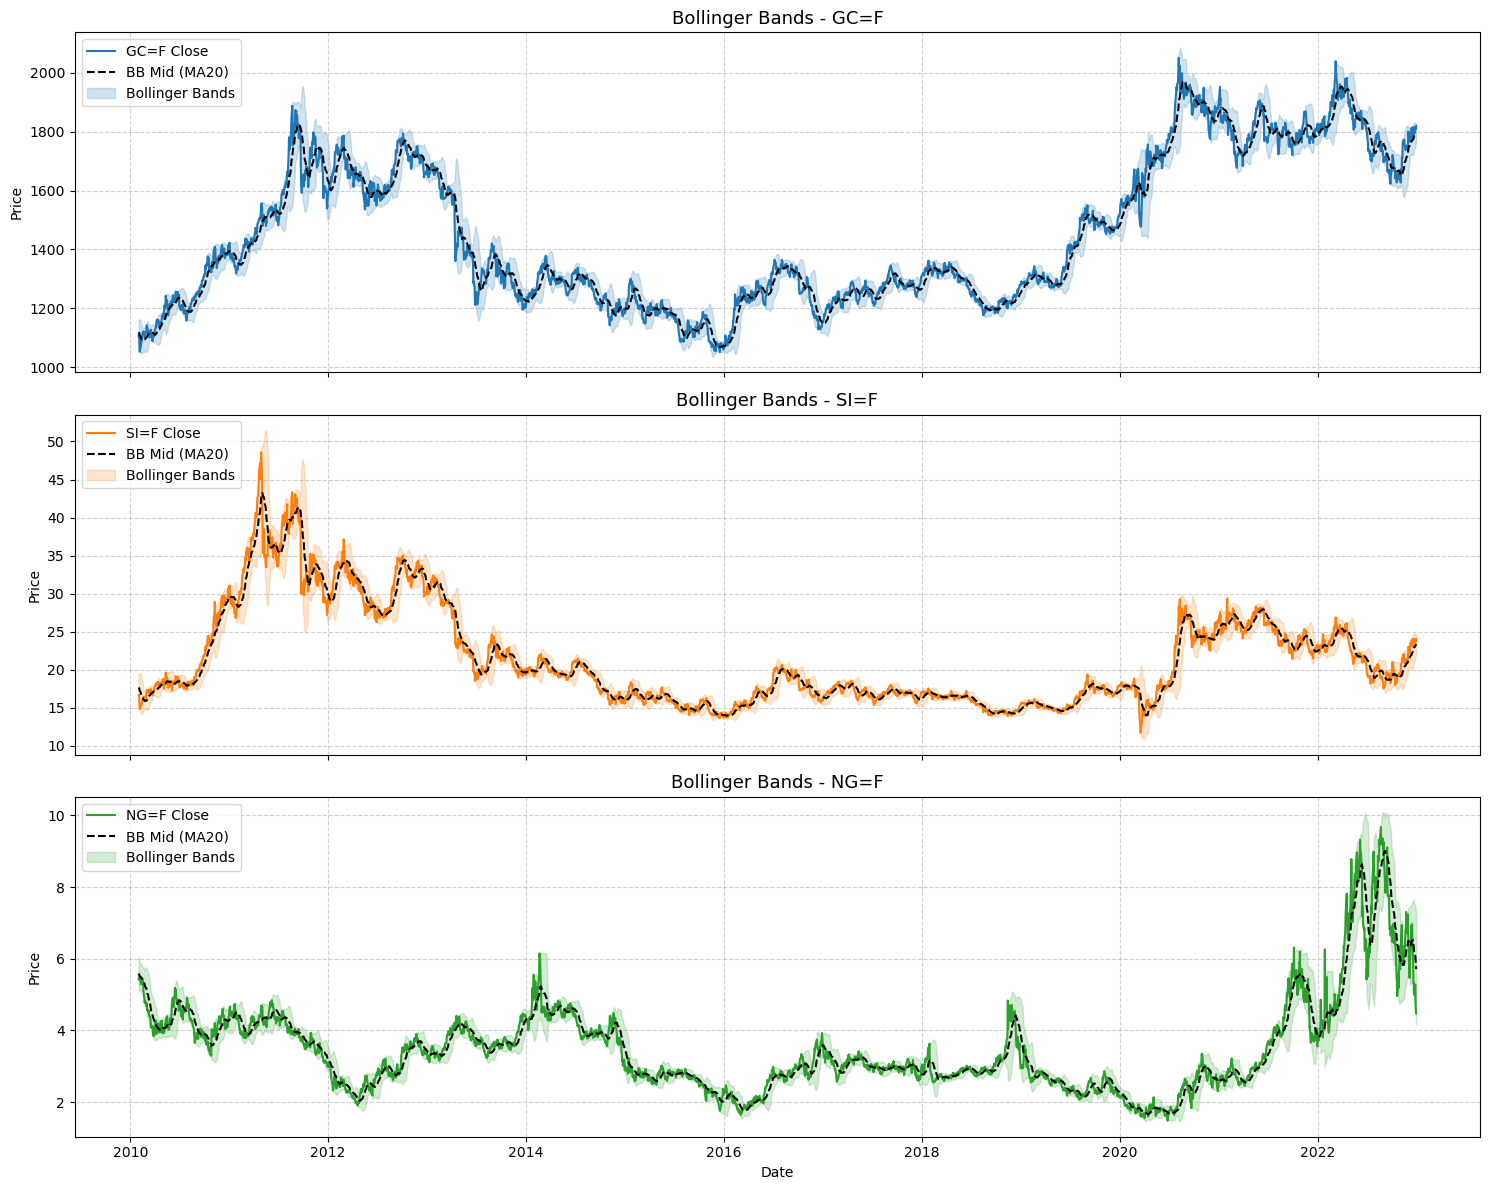

In [41]:
def add_bollinger_bands(df:pd.DataFrame, window:int=20):
    """Compute bollinger bands for a determined rolling window.

    Args:
        df (pd.DataFrame): original dataframe
        window (int, optional): rolling window size. Defaults to 20.

    Returns:
        pd.DataDrame: Dataframe with bollinger bands added
    """
    pd.options.mode.chained_assignment = None # Ignore warnings
    df['BB_Mid'] = df['Close'].rolling(window=window).mean()
    df['BB_Std'] = df['Close'].rolling(window=window).std()
    df['BB_Upper'] = df['BB_Mid'] + 2 * df['BB_Std']
    df['BB_Lower'] = df['BB_Mid'] - 2 * df['BB_Std']
    return df.dropna()

boilinger_bands = copy.deepcopy(commodities_data)
for ticker in commodities:
    boilinger_bands[ticker] = add_bollinger_bands(boilinger_bands[ticker])

fig, axs = plt.subplots(3, 1, figsize=(15, 12), sharex=True)
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

for i, ticker in enumerate(commodities):
    df = boilinger_bands[ticker]
    axs[i].plot(df.index, df['Close'], label=f"{ticker} Close", color=colors[i])
    axs[i].plot(df.index, df['BB_Mid'], label='BB Mid (MA20)', color='black', linestyle='--')
    axs[i].fill_between(df.index, df['BB_Upper'], df['BB_Lower'], color=colors[i], alpha=0.2, label='Bollinger Bands')

    axs[i].set_title(f"Bollinger Bands - {ticker}", fontsize=13)
    axs[i].set_ylabel("Price")
    axs[i].legend(loc='upper left')
    axs[i].grid(True, linestyle='--', alpha=0.6)

axs[-1].set_xlabel("Date")
plt.tight_layout()
plt.show()

## Data preprocessing

In [42]:
def normalize_indicators(df:pd.DataFrame):
    """Normalize with MinMaxScaler the data

    Args:
        df (pd.DataFrame): Original dataframe

    Returns:
        pd.DataFrame: Dataframe normalized
    """
    scaler = MinMaxScaler(feature_range=(0.1,1))
    cols_to_exclude = [] # If needed
    numeric_columns = df.select_dtypes(include=[np.number]).columns
    columns_to_scale = [col for col in numeric_columns if col not in cols_to_exclude]
    df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])
    return df, scaler

def add_technical_indicators(df):
    # RSI
    delta = df['Close'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=14).mean()
    avg_loss = loss.rolling(window=14).mean()
    rs = avg_gain / avg_loss
    df['RSI'] = 100 - (100 / (1 + rs))
    
    # MACD
    df['EMA12'] = df['Close'].ewm(span=12, adjust=False).mean()
    df['EMA26'] = df['Close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = df['EMA12'] - df['EMA26']
    df['Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()

    # Bollinger Bands
    df['BB_Mid'] = df['Close'].rolling(window=20).mean()
    df['BB_Std'] = df['Close'].rolling(window=20).std()
    df['BB_Upper'] = df['BB_Mid'] + 2 * df['BB_Std']
    df['BB_Lower'] = df['BB_Mid'] - 2 * df['BB_Std']
    
    # CCI
    tp = (df['High'] + df['Low'] + df['Close']) / 3
    sma_tp = tp.rolling(window=20).mean()
    mean_dev = tp.rolling(window=20).apply(lambda x: np.mean(np.abs(x - x.mean())))
    df['CCI'] = (tp - sma_tp) / (0.015 * mean_dev)
    
    # Volume
    df['Volume'] = np.log1p(df['Volume']) 
    df['Volume'] = (df['Volume'] - df['Volume'].rolling(20).mean()) / df['Volume'].rolling(20).std()

    df.dropna(inplace=True)
    return df

In [43]:
scalers = {}
for ticker in commodities:
    commodities_data[ticker] = add_technical_indicators(commodities_data[ticker])
    commodities_data[ticker], scaler = normalize_indicators(commodities_data[ticker])
    scalers[ticker] = scaler

print(commodities_data['GC=F'].head())

Price          Close      High       Low      Open    Volume       RSI  \
Date                                                                     
2010-02-01  0.148116  0.140366  0.128589  0.125884  0.635682  0.400956   
2010-02-02  0.159898  0.150347  0.149759  0.158598  0.639514  0.506738   
2010-02-03  0.154502  0.156050  0.157358  0.157160  0.579464  0.461612   
2010-02-04  0.110433  0.143396  0.112485  0.151947  0.596767  0.339994   
2010-02-05  0.101259  0.105792  0.100000  0.100000  0.602087  0.343365   

Price          EMA12     EMA26      MACD    Signal    BB_Mid    BB_Std  \
Date                                                                     
2010-02-01  0.133308  0.137751  0.432203  0.444661  0.147308  0.274425   
2010-02-02  0.135654  0.138264  0.445771  0.441698  0.147293  0.274416   
2010-02-03  0.136723  0.138280  0.453485  0.441190  0.146958  0.274609   
2010-02-04  0.130144  0.134541  0.431602  0.435499  0.143286  0.298176   
2010-02-05  0.123019  0.130298  0.409

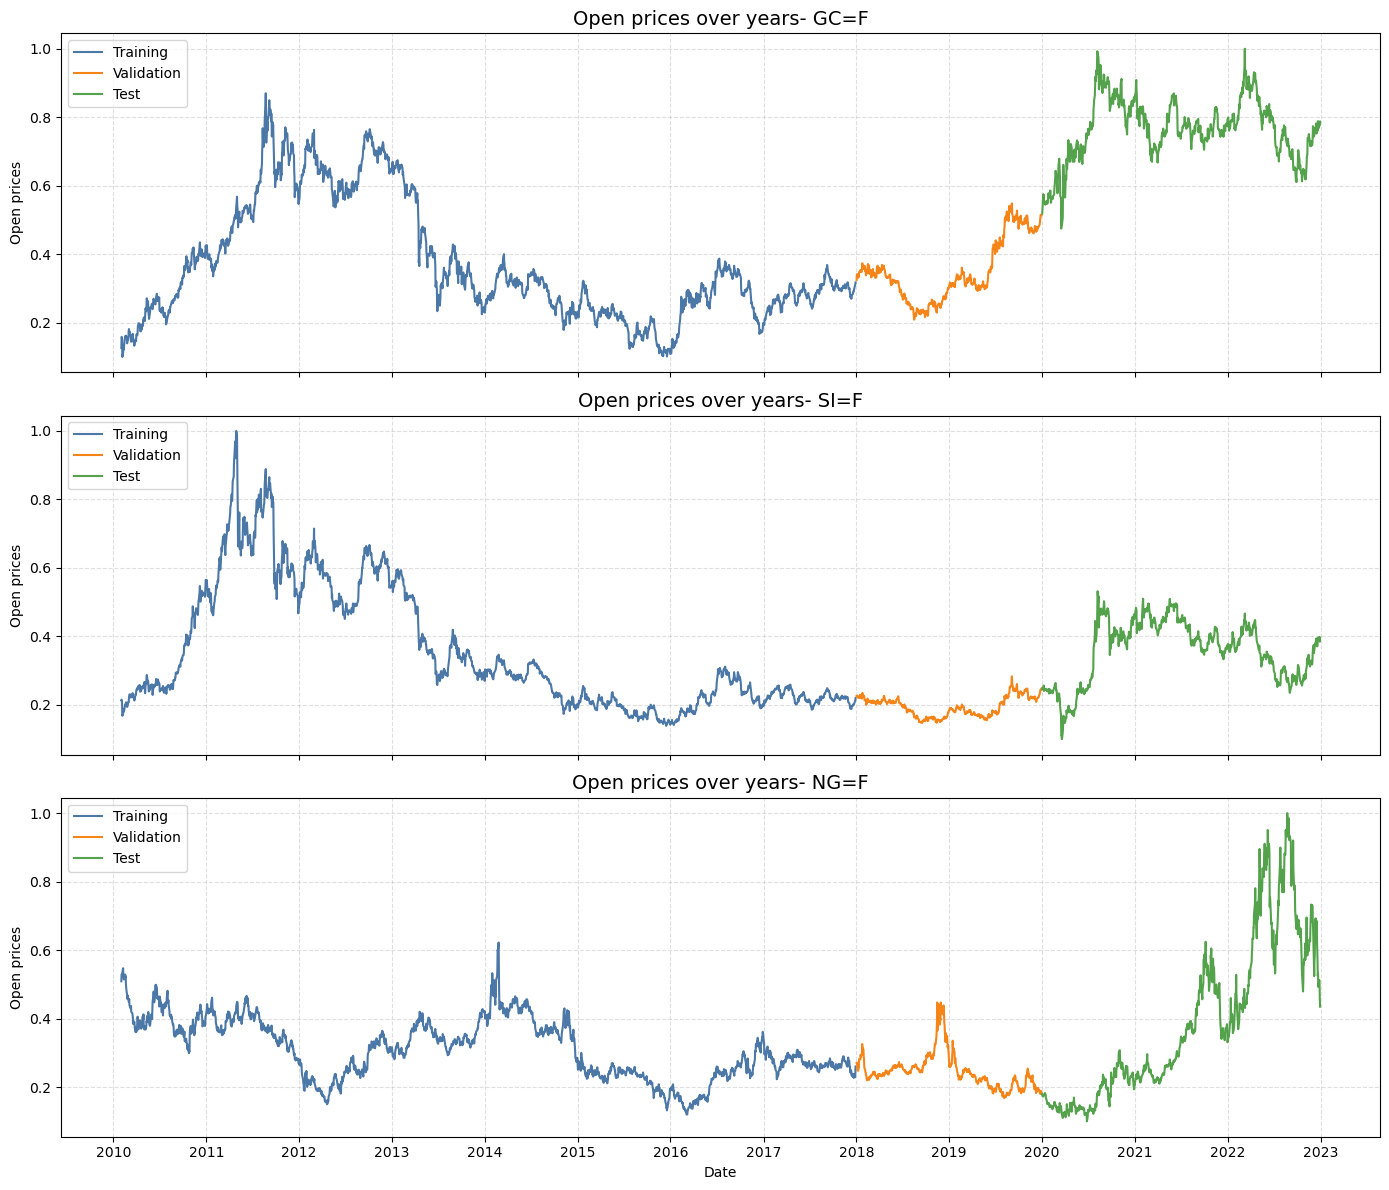

In [44]:
training_data_time_range = ('2010-01-01', '2017-12-31')
validation_data_time_range = ('2018-01-01', '2019-12-31')
test_data_time_range = ('2020-01-01', '2023-01-01')

training_data = {ticker: df.loc[training_data_time_range[0]:training_data_time_range[1]] for ticker, df in commodities_data.items()}
validation_data = {ticker: df.loc[validation_data_time_range[0]:validation_data_time_range[1]] for ticker, df in commodities_data.items()}
test_data = {ticker: df.loc[test_data_time_range[0]:test_data_time_range[1]] for ticker, df in commodities_data.items()}

def plot_train_test_split(training_data, validation_data, test_data):
    """Plot the graphs for each ticker and their train test split.

    Args:
        training_data (dict)
        validation_data (dict)
        test_data (dict)
    """
   
    tickers = ['GC=F', 'SI=F', 'NG=F']
    
    fig, axes = plt.subplots(len(tickers), 1, figsize=(14, 4 * len(tickers)), sharex=True)

    colors = {
        'Training': '#4c78a8',     
        'Validation': '#f58518',   
        'Test': '#54a24b'          
    }

    for i, ticker in enumerate(tickers):
        ax = axes[i]
        ax.plot(training_data[ticker]['Open'], label='Training', color=colors['Training'], linewidth=1.5)
        ax.plot(validation_data[ticker]['Open'], label='Validation', color=colors['Validation'], linewidth=1.5)
        ax.plot(test_data[ticker]['Open'], label='Test', color=colors['Test'], linewidth=1.5)

        ax.set_title(f'Open prices over years- {ticker}', fontsize=14)
        ax.set_ylabel("Open prices")
        ax.grid(True, linestyle='--', alpha=0.4)
        ax.legend(loc='upper left')
        ax.xaxis.set_major_locator(mdates.YearLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

    axes[-1].set_xlabel("Date")
    plt.tight_layout()
    plt.show()

plot_train_test_split(training_data, validation_data, test_data)

As we can see here, the data have been normalized between 0.1 and 1. This is a major simplifying assumption we made in order to make the problem more affordable. Indeed, the DQN policy network has difficulty processing non-normalized data, and it was very difficult to converge on a trading strategy that worked. All the more so as we chose to trade on 3 assets at the same time which had considerable price differentials: gold is around 2000 while gas is around 8 dollars. This price difference made the task even more complex.

# Commidity Trading Environment

In [6]:
class CommodityTradingEnv(gym.Env):

    def __init__(self, commodity_data, scalers, transaction_cost_percent=0.002, initial_balance=100):
        super(CommodityTradingEnv, self).__init__()

        self.commodity_data = {ticker: df for ticker, df in commodity_data.items() if not df.empty}
        self.tickers = list(self.commodity_data.keys())
        if not self.tickers:
            raise ValueError("No data")

        sample_df = next(iter(self.commodity_data.values()))
        self.n_features = len(sample_df.columns)

        self.action_list = [-1, -0.75, -0.50, -0.25, 0, 0.25, 0.50, 0.75, 1]
        self.num_actions_per_commodity = len(self.action_list)
        self.action_space = spaces.Discrete(self.num_actions_per_commodity ** len(self.tickers))

        self.obs_shape = self.n_features * len(self.tickers) + 2 + len(self.tickers) + 1
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(self.obs_shape,), dtype=np.float32)

        self.scalers = scalers
        self.net_worth_change_pct = 0
        self.initial_balance = initial_balance  
        self.transaction_cost_percent = transaction_cost_percent
        self.max_steps = max(0, min(len(df) for df in self.commodity_data.values()) - 1)
        self.reset()

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.balance = self.initial_balance
        self.net_worth = self.initial_balance
        self.max_net_worth = self.initial_balance
        self.shares_held = {ticker: 0 for ticker in self.tickers}
        self.current_step = 0
        self.net_worth_change_pct = 0
        return self._next_observation(), {}

    def _next_observation(self):
        frame = np.zeros(self.obs_shape)
        idx = 0
        for ticker in self.tickers:
            df = self.commodity_data[ticker]
            if self.current_step < len(df):
                frame[idx:idx+self.n_features] = df.iloc[self.current_step].values
            else:
                frame[idx:idx+self.n_features] = df.iloc[-1].values
            idx += self.n_features

        frame[-(len(self.tickers)+2)] = self.balance
        frame[-(len(self.tickers)+2):-2] = [self.shares_held[ticker] for ticker in self.tickers]
        frame[-2] = self.net_worth
        frame[-1] = self.current_step

        return frame

    def decode_action(self, action):
        decoded_indices = []
        temp = action
        for _ in range(len(self.tickers)):
            decoded_indices.append(temp % self.num_actions_per_commodity)
            temp //= self.num_actions_per_commodity
        decoded_indices.reverse()
        return [self.action_list[idx] for idx in decoded_indices]

    def step(self, action):
        actions = self.decode_action(action)
        prev_net_worth = self.net_worth
        self.current_step += 1
        if self.current_step > self.max_steps:
            return self._next_observation(), 0, True, False, {}

        penalty = 0
        current_prices = {}
        for i, ticker in enumerate(self.tickers):
            price_norm = float(self.commodity_data[ticker]['Close'].iloc[self.current_step])
            act = actions[i]
            current_prices[ticker] = price_norm

            # Penalty for sale when agent holds no shares
            if act < 0 and self.shares_held[ticker] <= 0:
                penalty -= 0.001
                continue

            # Buy
            if act > 0:
                shares_to_buy = int(self.balance * act / price_norm)
                cost = shares_to_buy * price_norm
                transaction_cost = cost * self.transaction_cost_percent
                if cost + transaction_cost <= self.balance and shares_to_buy > 0:
                    self.balance -= (cost + transaction_cost)
                    self.shares_held[ticker] += shares_to_buy

            # Sale
            elif act < 0:
                shares_to_sell = int(self.shares_held[ticker] * abs(act))
                shares_to_sell = min(shares_to_sell, self.shares_held[ticker])
                if shares_to_sell > 0:
                    sale = shares_to_sell * price_norm
                    transaction_cost = sale * self.transaction_cost_percent
                    self.balance += (sale - transaction_cost)
                    self.shares_held[ticker] -= shares_to_sell

        self.net_worth = self.balance + sum(self.shares_held[ticker] * current_prices[ticker] for ticker in self.tickers)
        self.max_net_worth = max(self.net_worth, self.max_net_worth)
        self.net_worth_change_pct = (self.net_worth - self.initial_balance) / self.initial_balance * 100
        reward = (self.net_worth - prev_net_worth) / (prev_net_worth + 1e-8) - penalty

        done = self.net_worth <= 0 or self.current_step >= self.max_steps
        return self._next_observation(), reward, done, False, {}

    def render(self):
        profit_pct = (self.net_worth - self.initial_balance) / self.initial_balance * 100
        print(f"Step: {self.current_step}")
        print(f"Balance: {self.balance:.2f}")
        for ticker in self.tickers:
            print(f"{ticker} Shares held: {self.shares_held[ticker]}")
        print(f"Net worth: {self.net_worth:.2f} | Profit: {profit_pct:.2f}%")

# DoubleDQN with LSTM

In [7]:
class ReplayBuffer:
    def __init__(self, capacity=100000):
        self.buffer = deque(maxlen=capacity)

    def push(self, state_seq, action, reward, next_state_seq, done):
        self.buffer.append((state_seq, action, reward, next_state_seq, done))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        return (
            np.array(states),    # shape: (batch, seq_len, obs_dim)
            np.array(actions),
            np.array(rewards, dtype=np.float32),
            np.array(next_states),
            np.array(dones, dtype=np.float32)
        )

    def __len__(self):
        return len(self.buffer)

In [8]:
class LSTMNetwork(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=128):
        super(LSTMNetwork, self).__init__()
        self.hidden_dim = hidden_dim
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # x shape: (batch, seq_len, input_dim)
        lstm_out, _ = self.lstm(x)
        lstm_out = lstm_out[:, -1, :]  
        out = self.fc(lstm_out)
        return out

In [9]:
class DoubleDQN:
    def __init__(self, env, learning_rate=1e-4, gamma=0.99, batch_size=32, device="cpu"):
        self.env = env
        self.device = torch.device(device)
        self.gamma = gamma
        self.batch_size = batch_size
        input_dim = env.observation_space.shape[0] 
        # The NN will recieve sequence of length 10
        self.seq_length = 10
        self.q_net = LSTMNetwork(input_dim, env.action_space.n).to(self.device)
        self.target_net = LSTMNetwork(input_dim, env.action_space.n).to(self.device)
        self.optimizer = optim.Adam(self.q_net.parameters(), lr=learning_rate)
        self.replay_buffer = ReplayBuffer()
        self.update_target_network(hard=True)

    def update_target_network(self, hard=True):
        if hard:
            self.target_net.load_state_dict(self.q_net.state_dict())
        else:
            for target_param, param in zip(self.target_net.parameters(), self.q_net.parameters()):
                target_param.data.copy_(0.995 * target_param.data + 0.005 * param.data)

    def train_step(self):
        if len(self.replay_buffer) < self.batch_size:
            return 0.0
        states, actions, rewards, next_states, dones = self.replay_buffer.sample(self.batch_size)
        states = torch.FloatTensor(states).to(self.device)           # shape: (batch, seq_len, obs_dim)
        actions = torch.LongTensor(actions).unsqueeze(1).to(self.device)
        rewards = torch.FloatTensor(rewards).unsqueeze(1).to(self.device)
        next_states = torch.FloatTensor(next_states).to(self.device)
        dones = torch.FloatTensor(dones).unsqueeze(1).to(self.device)

        # Compute Q with Dual DQN
        next_q = self.q_net(next_states)
        next_actions = next_q.argmax(dim=1, keepdim=True)
        next_q_target = self.target_net(next_states).gather(1, next_actions)

        target_q = rewards + (1 - dones) * self.gamma * next_q_target
        current_q = self.q_net(states).gather(1, actions)
        loss = nn.MSELoss()(current_q, target_q)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        return loss.item()

    def predict(self, state_seq):
        # state_seq : (seq_len, obs_dim)
        obs_tensor = torch.FloatTensor(state_seq).unsqueeze(0).to(self.device)  # (1, seq_len, obs_dim)
        with torch.no_grad():
            q_values = self.q_net(obs_tensor)
        action = torch.argmax(q_values, dim=1).item()
        return action
    
    @classmethod
    def load(cls, path, env, device="cpu", **kwargs):
        agent = cls(env=env, device=device, **kwargs)
        agent.q_net.load_state_dict(torch.load(path, map_location=device))
        agent.update_target_network(hard=True)
        return agent

## Training DoubleDQN Agent

In [161]:
env_train = DummyVecEnv([lambda: CommodityTradingEnv(training_data, scalers=scalers)])
env_val = DummyVecEnv([lambda: CommodityTradingEnv(validation_data, scalers=scalers)])
env_test = DummyVecEnv([lambda: CommodityTradingEnv(test_data, scalers=scalers)])

model = DoubleDQN(env_train, device="cpu", batch_size=32)
best_val_reward = -np.inf
best_model_path = "best_model.pth"

SEQ_LENGTH = 10
EPOCHS = 10

train_losses = []
train_rewards = []
val_rewards = []

for epoch in tqdm(range(EPOCHS), desc='Training DQN agent'):

    obs_batch = env_train.reset()
    obs = obs_batch[0] 
    state_deque = deque([obs.copy() for _ in range(SEQ_LENGTH)], maxlen=SEQ_LENGTH)
    state_seq = np.array(state_deque)
    
    epoch_reward = 0
    epoch_loss = 0
    done = False

    for step in range(1000):
        epsilon = max(0.05, 1.0 - (epoch * 1000 + step) / 50000)
        if np.random.rand() < epsilon:
            action = env_train.action_space.sample()
        else:
            action = model.predict(state_seq)

        next_obs_batch, reward, done, _ = env_train.step([action])
        next_obs = next_obs_batch[0]
      
        state_deque.append(next_obs)
        next_state_seq = np.array(state_deque)
        
        model.replay_buffer.push(state_seq, action, reward, next_state_seq, done)
        state_seq = next_state_seq
        epoch_reward += reward

        if len(model.replay_buffer) > 1000:
            loss = model.train_step()
            epoch_loss += loss

        if done:
            obs_batch = env_train.reset()
            obs = obs_batch[0]
            state_deque = deque([obs.copy() for _ in range(SEQ_LENGTH)], maxlen=SEQ_LENGTH)
            state_seq = np.array(state_deque)
    
    avg_loss = epoch_loss / 1000 if epoch_loss > 0 else 0.0
    epoch_reward_val = epoch_reward.item() if hasattr(epoch_reward, "item") else epoch_reward
    train_losses.append(avg_loss)
    train_rewards.append(epoch_reward_val)
    
    print(f"Train Reward: {epoch_reward_val:.2f} | Train Loss: {avg_loss:.4f}")

    val_reward = 0
    obs_batch = env_val.reset()
    obs = obs_batch[0]
    state_deque = deque([obs.copy() for _ in range(SEQ_LENGTH)], maxlen=SEQ_LENGTH)
    state_seq = np.array(state_deque)
    done = False
    while not done:
        action = model.predict(state_seq)
        next_obs_batch, reward, done, _ = env_val.step([action])
        next_obs = next_obs_batch[0]
        state_deque.append(next_obs)
        state_seq = np.array(state_deque)
        val_reward += reward
    val_reward = val_reward.item() if hasattr(val_reward, "item") else val_reward
    val_rewards.append(val_reward)
    print(f"Validation Reward: {val_reward:.2f}")

    if val_reward > best_val_reward:
        best_val_reward = val_reward
        torch.save(model.q_net.state_dict(), best_model_path)
        print(f"Meilleur modèle sauvegardé avec reward = {best_val_reward:.2f}")

Training DQN agent:   0%|          | 0/10 [00:00<?, ?it/s]

Train Reward: 0.19 | Train Loss: 0.0000
Validation Reward: 0.21
Meilleur modèle sauvegardé avec reward = 0.21


/home/marius/envs/main_venv/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([32, 32, 1])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Train Reward: 1.06 | Train Loss: 0.2528
Validation Reward: 0.14
Train Reward: -0.18 | Train Loss: 0.0451
Validation Reward: 1.10
Meilleur modèle sauvegardé avec reward = 1.10
Train Reward: 0.25 | Train Loss: 0.0452
Validation Reward: -0.04
Train Reward: 0.71 | Train Loss: 0.0492
Validation Reward: 0.31
Train Reward: -0.02 | Train Loss: 0.0616
Validation Reward: 1.04
Train Reward: -0.02 | Train Loss: 0.0529
Validation Reward: 0.18
Train Reward: -0.34 | Train Loss: 0.0463
Validation Reward: 0.89
Train Reward: 0.12 | Train Loss: 0.0536
Validation Reward: 0.67
Train Reward: 0.00 | Train Loss: 0.0503
Validation Reward: 0.30


## Test the best model saved

In [20]:
model = DoubleDQN.load(best_model_path, env=env_test, device="cpu")
env_test = DummyVecEnv([lambda: CommodityTradingEnv(test_data, scalers=scalers)])
test_rewards = []
test_cumulative_reward = 0

# Initialisation of sequence for test
obs_batch = env_test.reset()
obs = obs_batch[0]
state_deque = deque([obs.copy() for _ in range(SEQ_LENGTH)], maxlen=SEQ_LENGTH)
state_seq = np.array(state_deque)
done = False

while not done:
    action = model.predict(state_seq)
    next_obs_batch, reward, done, _ = env_test.step([action])
    next_obs = next_obs_batch[0]
    state_deque.append(next_obs)
    state_seq = np.array(state_deque)
    reward_val = reward.item() if hasattr(reward, "item") else reward
    test_rewards.append(reward_val)
    test_cumulative_reward += reward_val

print(f"Test Cumulative Reward: {test_cumulative_reward:.2f}")

Test Cumulative Reward: 2.06


## Performances

In [163]:
def plot_reward_distribution(rewards):
    """Plot the reward distribution in Histogram.

    Args:
        rewards (list): list of the rewards accumulated during each step
    """
    plt.figure(figsize=(10, 6))
    plt.hist(rewards, bins=100, color='skyblue', edgecolor='black')
    plt.title("Distribution des récompenses sur le set de test")
    plt.xlabel("Récompense")
    plt.ylabel("Fréquence")
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()

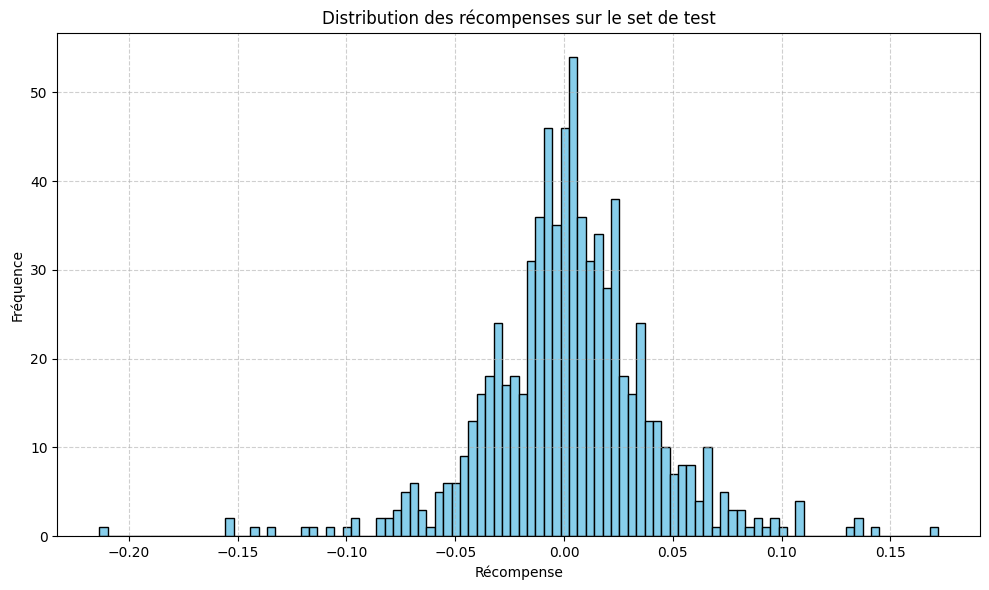

In [164]:
plot_reward_distribution(test_rewards)

## Visualization of trading strategy on Test set

In [25]:
def plot_trading_strategy(env, model, n_steps=200):
    """plot for each commodity, the trading strategy adopted, with buy and sell signals.

    Args:
        env : trading environment
        model : model trained
        n_steps (int, optional): number of steps. Defaults to 200.
    """
    obs_batch = env.reset()
    obs = obs_batch[0]
    state_deque = deque([obs.copy() for _ in range(SEQ_LENGTH)], maxlen=SEQ_LENGTH)
    state_seq = np.array(state_deque)
    done = False
    step_count = 0

    price_history = {ticker: [] for ticker in env.envs[0].tickers}
    action_history = {ticker: [] for ticker in env.envs[0].tickers}
    shares_held_history = {ticker: [] for ticker in env.envs[0].tickers}
    date_history = []

    while not done and step_count < n_steps:
        step_count += 1
        action = model.predict(state_seq)
        decoded_actions = env.envs[0].decode_action(action)

        current_step_in_env = env.envs[0].current_step
        date_index = env.envs[0].commodity_data[env.envs[0].tickers[0]].index[current_step_in_env]
        date_history.append(date_index)

        for i, ticker in enumerate(env.envs[0].tickers):
            price_norm = env.envs[0].commodity_data[ticker]['Close'].iloc[current_step_in_env]
            scaler = env.envs[0].scalers[ticker]
            min_val = scaler.data_min_[1]  # Close Column
            max_val = scaler.data_max_[1]
            price = price_norm * (max_val - min_val) + min_val
            shares_held = env.envs[0].shares_held[ticker]

            price_history[ticker].append(price)
            action_history[ticker].append(decoded_actions[i])
            shares_held_history[ticker].append(shares_held)

        next_obs_batch, _, done, _ = env.step([action])
        next_obs = next_obs_batch[0]
        state_deque.append(next_obs)
        state_seq = np.array(state_deque)

    for ticker in env.envs[0].tickers:
        fig, axs = plt.subplots(3, 1, figsize=(14, 9), sharex=True, height_ratios=[2, 1, 1])
        fig.suptitle(f"Trading Strategy - {ticker}", fontsize=14)

        axs[0].plot(date_history, price_history[ticker], label="Price", color='black', linewidth=1.5)
        label_sell = label_buy = False
        for i, act in enumerate(action_history[ticker]):
            if act > 0:
                if not label_buy:
                    axs[0].scatter(date_history[i], price_history[ticker][i], marker='^', color='green', s=40, label='Buy')
                    label_buy = True
                else:
                    axs[0].scatter(date_history[i], price_history[ticker][i], marker='^', color='green', s=40)
            elif act < 0:
                if not label_sell:
                    axs[0].scatter(date_history[i], price_history[ticker][i], marker='v', color='red', s=40, label='Sell')
                    label_sell = True
                else:
                    axs[0].scatter(date_history[i], price_history[ticker][i], marker='v', color='red', s=40)
        axs[0].set_ylabel("Price")
        axs[0].legend(loc='upper left')
        axs[0].grid(True)

        intensities = action_history[ticker]
        colors = ['green' if a > 0 else 'red' if a < 0 else 'gray' for a in intensities]
        axs[1].bar(date_history, intensities, color=colors, width=1)
        axs[1].set_ylabel("Action Intensity")
        axs[1].grid(True)

        axs[2].plot(date_history, shares_held_history[ticker], label='Shares Held', color='blue', linewidth=1.2)
        axs[2].set_ylabel("Shares Held")
        axs[2].set_xlabel("Date")
        axs[2].grid(True)
        axs[2].legend(loc='upper left')
        axs[2].xaxis.set_major_locator(mdates.MonthLocator(interval=2))
        axs[2].xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
        fig.autofmt_xdate()

        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()

In [21]:
def get_metrics(env, model, n_tests, visualize=False):
    """Test the agent, and compute a dictionnary to store its metrics.

    Args:
        env : trading enviroment
        model : model trained
        n_tests (int): number of steps 
        visualize (bool, optional): Wheter to verbose or ot. Defaults to False.

    Returns:
        dict: metrics computed for each steps
    """
    metrics = {
        'steps': [],
        'balances': [],
        'net_worths_pct': [],
        'shares_held': {ticker: [] for ticker in env.envs[0].commodity_data.keys()}
    }
    
    obs_batch = env.reset()
    obs = obs_batch[0]
    state_deque = deque([obs.copy() for _ in range(SEQ_LENGTH)], maxlen=SEQ_LENGTH)
    state_seq = np.array(state_deque)
    for i in range(n_tests):
        metrics['steps'].append(i)
        action = model.predict(state_seq)
        next_obs_batch, reward, done, info = env.step([action])
        next_obs = next_obs_batch[0]
        state_deque.append(next_obs)
        state_seq = np.array(state_deque)
        metrics['balances'].append(env.envs[0].balance)
        metrics['net_worths_pct'].append(env.envs[0].net_worth_change_pct)
        for ticker in env.envs[0].commodity_data.keys():
            metrics['shares_held'][ticker].append(env.envs[0].shares_held[ticker])
        if done:
            obs_batch = env.reset()
            obs = obs_batch[0]
            state_deque = deque([obs.copy() for _ in range(SEQ_LENGTH)], maxlen=SEQ_LENGTH)
            state_seq = np.array(state_deque)
    return metrics

In [22]:
max_days = env_test.envs[0].max_steps - 1
test_metrics = get_metrics(env_test, model, n_tests=max_days, visualize=False)

In [11]:
def plot_net_worth(test_metrics, env):
    """Plot the Net Worth accumulated at each step of our agent.

    Args:
        test_metrics (dict): metrics computed for each steps
        env : trading environment
    """
    df_index = env.envs[0].commodity_data[env.envs[0].tickers[0]].index
    dates = df_index[:len(test_metrics['net_worths_pct'])]
    plt.figure(figsize=(12,6))
    plt.plot(dates, test_metrics['net_worths_pct'], label="Net Worth (%)", color='blue', linewidth=1.8)
    plt.title("Évolution du Net Worth sur le set de Test")
    plt.xlabel("Date")
    plt.ylabel("Net Worth (%)")
    plt.grid(True)
    plt.legend()
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2))
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    plt.gcf().autofmt_xdate()
    plt.tight_layout()
    plt.show()

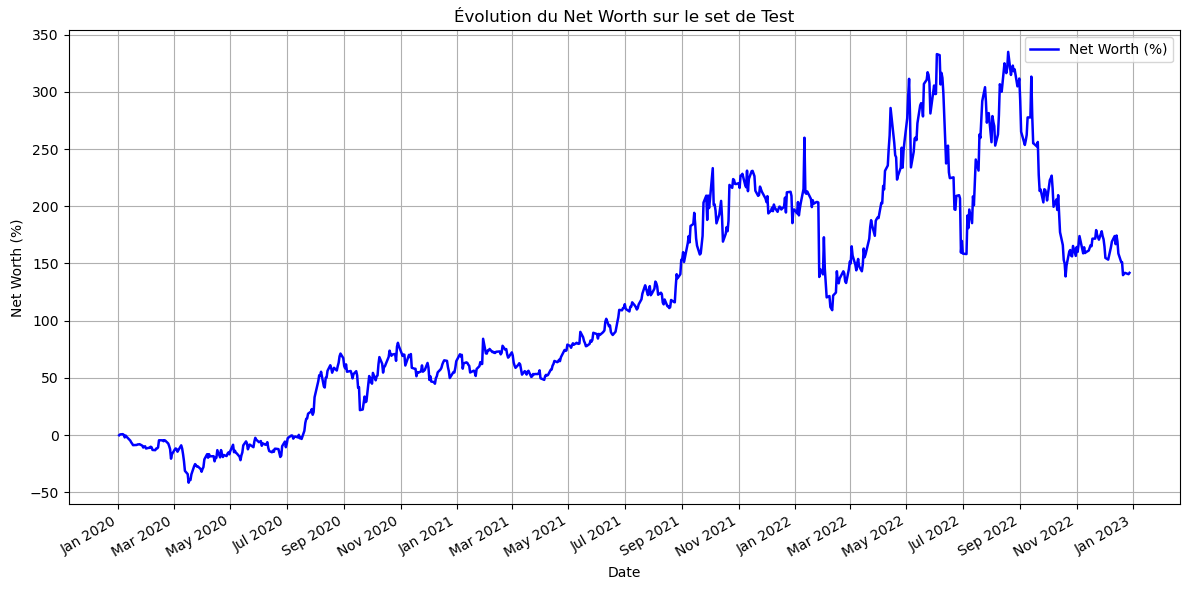

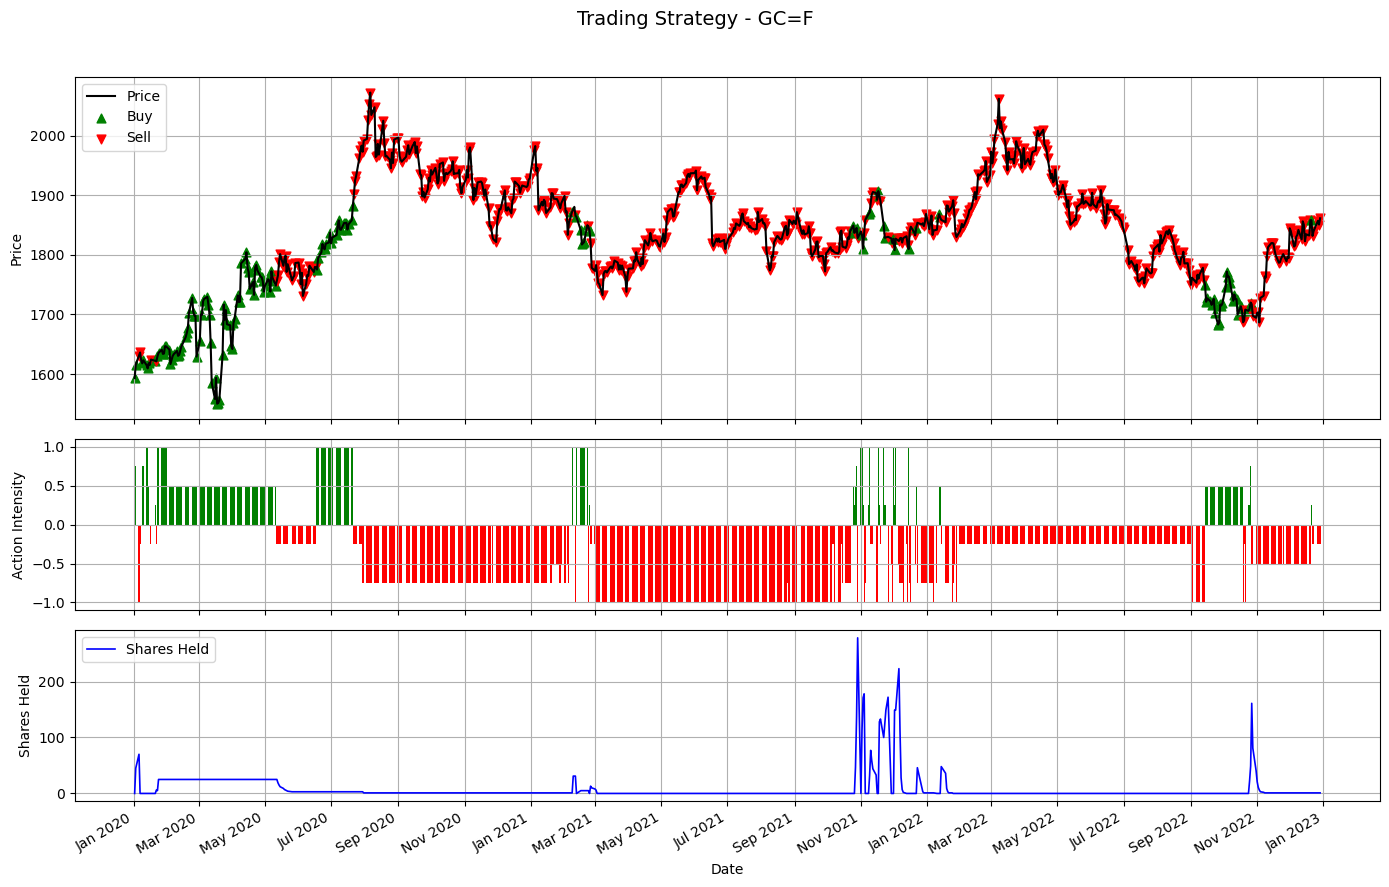

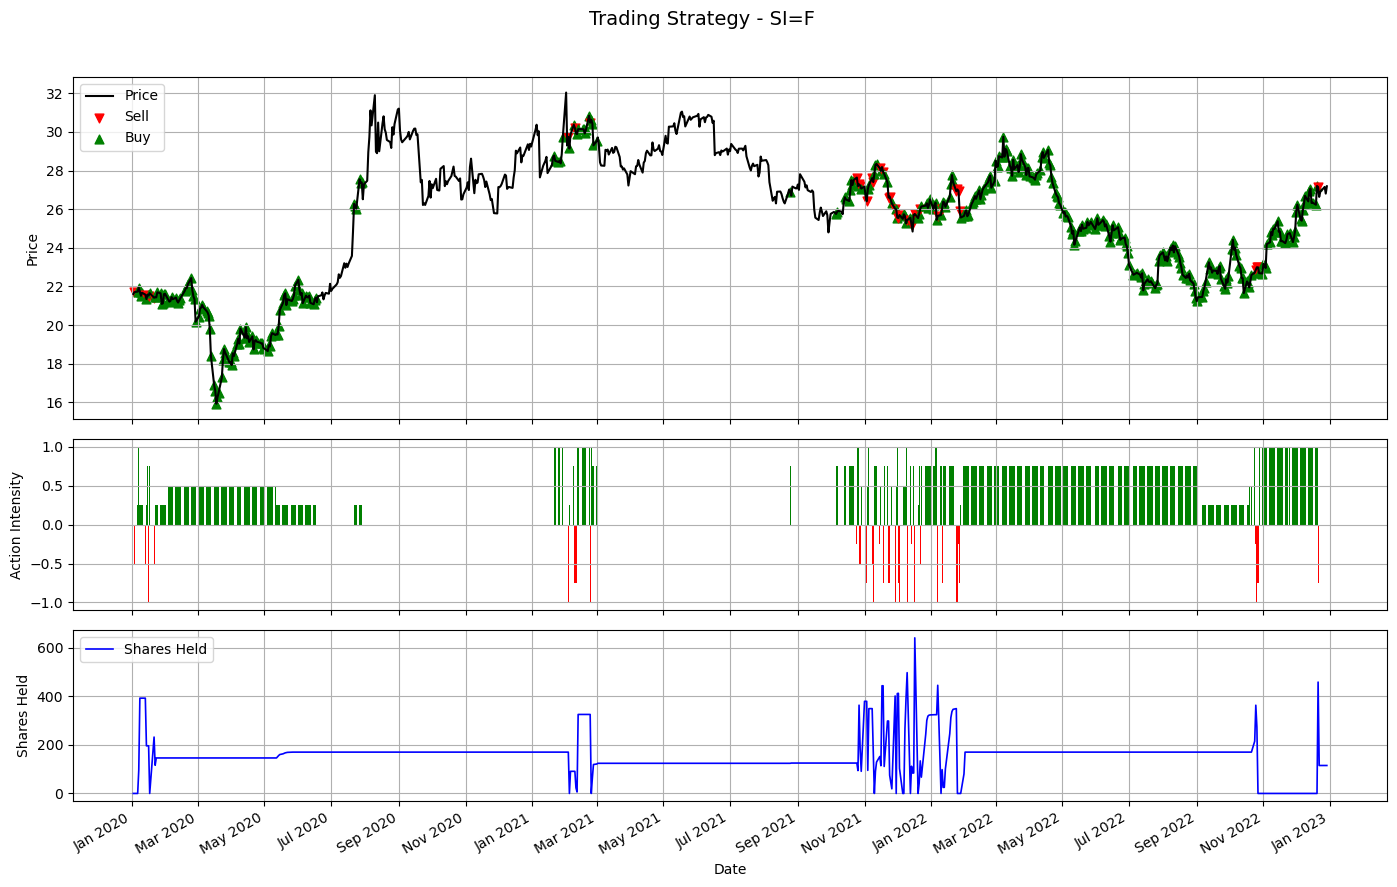

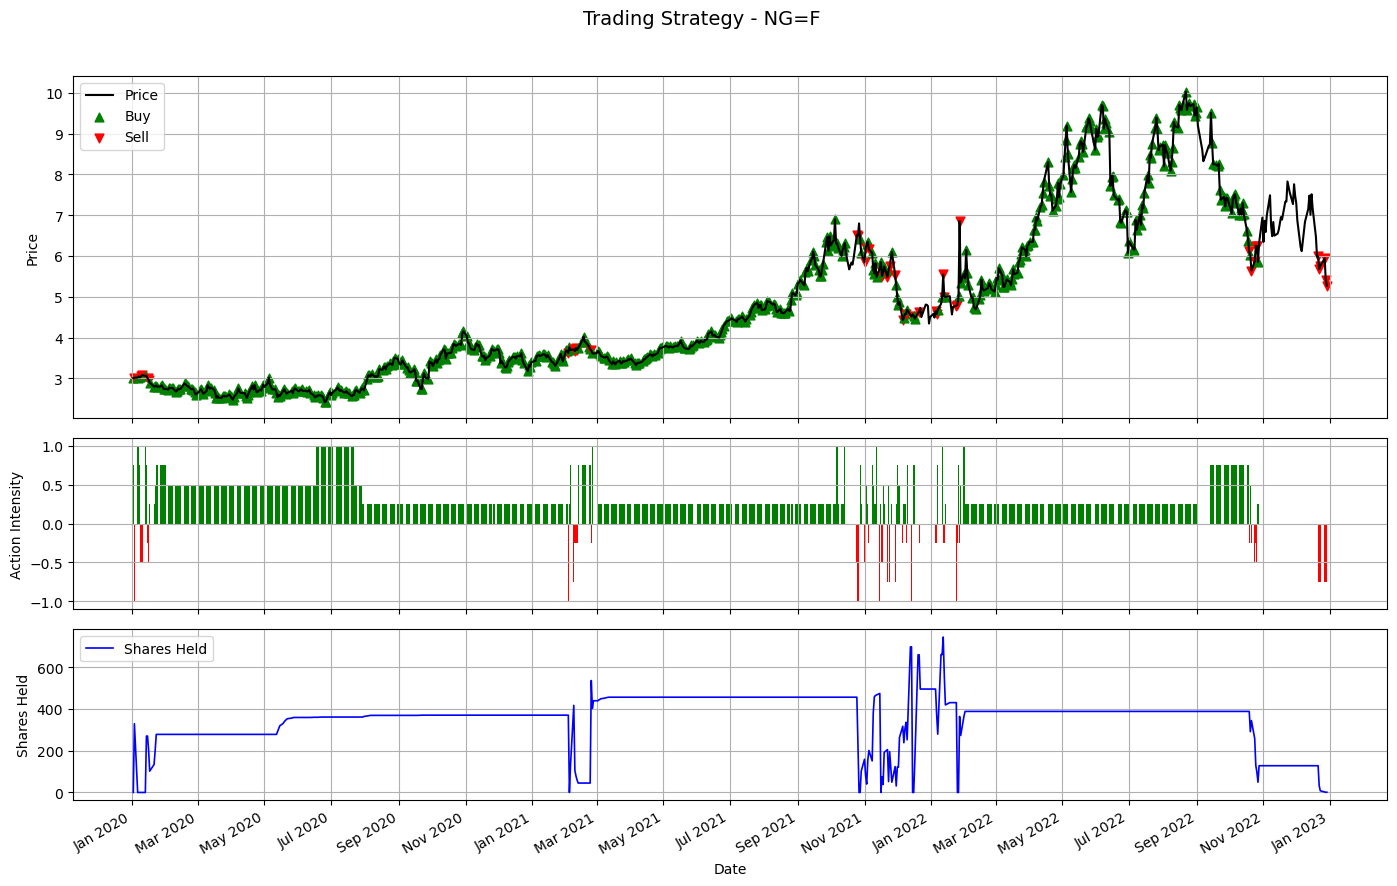

In [25]:
plot_net_worth(test_metrics=test_metrics, env=env_test)
plot_trading_strategy(env_test, model, n_steps=env_test.envs[0].max_steps)

In [23]:
def compute_returns(net_worths_pct):
    """Convert pourcentage into ratio

    Args:
        net_worths_pct (list): pourcentage of net worth evolution

    Returns:
       list: pourcentage of net worth converted
    """
    net_worths = np.array(net_worths_pct) / 100 + 1 
    returns = np.diff(net_worths) / net_worths[:-1]
    return returns

def compute_performance_metrics(net_worths_pct, risk_free_rate=0.0):
    """Compute performance metrics for an agent.

    Args:
        net_worths_pct (list): pourcentage of net worth evolution
        risk_free_rate (float, optional): metric for sharpe ratio. Defaults to 0.0.

    Returns:
        dict: dictionnary of performance metrics
    """
    returns = compute_returns(net_worths_pct)
    if len(returns) == 0:
        return {}

    mean_return = np.mean(returns)
    std_return = np.std(returns)
    downside_returns = returns[returns < 0]
    sortino_denominator = np.std(downside_returns) if len(downside_returns) > 0 else 1e-8

    sharpe_ratio = (mean_return - risk_free_rate) / (std_return + 1e-8)
    sortino_ratio = (mean_return - risk_free_rate) / sortino_denominator

    # Drawdown
    equity_curve = np.array(net_worths_pct) / 100 + 1
    running_max = np.maximum.accumulate(equity_curve)
    drawdowns = 1 - equity_curve / running_max
    max_drawdown = np.max(drawdowns)
    avg_drawdown = np.mean(drawdowns)

    calmar_ratio = mean_return / (max_drawdown + 1e-8)

    # % of positive returns
    pct_positive = np.mean(returns > 0)

    # Average profit / Average loss
    gains = returns[returns > 0]
    losses = -returns[returns < 0]
    avg_p = np.mean(gains) if len(gains) > 0 else 0
    avg_l = np.mean(losses) if len(losses) > 0 else 1e-8
    profit_loss_ratio = avg_p / avg_l

    return {
        "E(R)": mean_return,
        "Std(R)": std_return,
        "DD": avg_drawdown,
        "Sharpe": sharpe_ratio,
        "Sortino": sortino_ratio,
        "MDD": max_drawdown,
        "Calmar": calmar_ratio,
        "Perc of +Ret": pct_positive,
        "Ave. P / Ave. L": profit_loss_ratio
    }


metrics = compute_performance_metrics(test_metrics['net_worths_pct'])
df_metrics = pd.DataFrame([metrics])
print(df_metrics.round(4))


     E(R)  Std(R)      DD  Sharpe  Sortino     MDD  Calmar  Perc of +Ret  \
0  0.0022   0.048  0.1601   0.045   0.0665  0.5266  0.0041        0.5286   

   Ave. P / Ave. L  
0            1.023  


# Bollinger Agent

In [12]:
class BollingerBaselineAgent:
    def __init__(self, env):
        self.env = env.envs[0] if hasattr(env, "envs") else env
        self.n_features = env.envs[0].n_features


    def predict(self, obs, state=None, episode_start=None, deterministic=True):
        """
        Determines the action based on Bollinger signals.
          - if Close < bb_lower => buy (1.0)
          - if Close > bb_upper => sell (-1.0)
          - else hold (0.0)
        """
        tickers = self.env.tickers
        n = len(tickers)
        actions = []
        obs = obs[0]
        
        for i in range(n):
            base_idx = i * self.n_features
            close = obs[base_idx + 3]
            bb_upper = obs[base_idx + 12]
            bb_lower = obs[base_idx + 13]
            
            if close < bb_lower:
                actions.append(1.0 / n)    # Signal full buy
            elif close > bb_upper:
                actions.append(-1.0 / n)   # Signal full sell
            else:
                actions.append(0.0)    # Hold
        
        action = self.encode_action(actions)
        return action, None

    def encode_action(self, action_vector):
        def closest(val):
            return min(range(len(self.env.action_list)), key=lambda i: abs(val - self.env.action_list[i]))
        
        index = 0
        base = self.env.num_actions_per_commodity
        for val in action_vector:
            idx = closest(val)
            index = index * base + idx
        return index

    def save(self, path):
        with open(path, "wb") as f:
            pickle.dump(self, f)
    
    @classmethod
    def load(cls, path):
        with open(path, "rb") as f:
            return pickle.load(f)

## Test agent

In [13]:
def get_bollinger_metrics(env, model, n_tests, visualize=False):
    """Test the agent, and compute a dictionnary to store its metrics.

    Args:
        env : trading enviroment
        model : model trained
        n_tests (int): number of steps 
        visualize (bool, optional): Wheter to verbose or ot. Defaults to False.

    Returns:
        dict: metrics computed for each steps
    """
    metrics = {
        'steps': [],
        'balances': [],
        'net_worths_pct': [],
        'shares_held': {ticker: [] for ticker in env.envs[0].commodity_data.keys()}
    }
    
    obs = env.reset()
    for i in range(n_tests):
        metrics['steps'].append(i)
        action, _ = model.predict(obs)
        obs, reward, done, info = env.step([action])
        if visualize:
            env.envs[0].render() 
        metrics['balances'].append(env.envs[0].balance)
        metrics['net_worths_pct'].append(env.envs[0].net_worth_change_pct)
        for ticker in env.envs[0].commodity_data.keys():
            metrics['shares_held'][ticker].append(env.envs[0].shares_held[ticker])
        if done:
            obs = env.reset()
    return metrics

In [14]:
bollinger_model = BollingerBaselineAgent(env_test)

obs = env_test.reset()
done = False
test_cumulative_reward = 0

while not done:
    action, _ = bollinger_model.predict(obs)
    
    obs, reward, done, info = env_test.step([action])

    test_cumulative_reward += reward[0]

print("Test cumulative reward:", test_cumulative_reward)

Test cumulative reward: 0.42692465


## Visualize performances

In [15]:
def plot_trading_strategy_bollinger(env, model, n_steps=200):
    """plot for each commodity, the trading strategy adopted, with buy and sell signals.

    Args:
        env : trading environment
        model : model trained
        n_steps (int, optional): number of steps. Defaults to 200.
    """
    obs = env.reset()
    done = False
    step_count = 0

    underlying_env = env.envs[0] if hasattr(env, "envs") else env
    tickers = underlying_env.tickers
    price_history = {ticker: [] for ticker in tickers}
    action_history = {ticker: [] for ticker in tickers}
    shares_held_history = {ticker: [] for ticker in env.envs[0].tickers}
    date_history = []

    while not done and step_count < n_steps:
        step_count += 1

        # Get action from the baseline agent
        action, _ = model.predict(obs)

        if hasattr(underlying_env, "decode_action"):
            decoded_actions = underlying_env.decode_action(action)
        else:
            decoded_actions = [action]

        current_step_in_env = underlying_env.current_step
        date_index = underlying_env.commodity_data[tickers[0]].index[current_step_in_env]
        date_history.append(date_index)

        for i, ticker in enumerate(tickers):
            price_norm = underlying_env.commodity_data[ticker]['Close'].iloc[current_step_in_env]

            scaler = underlying_env.scalers[ticker]
            min_val = scaler.data_min_[1]
            max_val = scaler.data_max_[1]

            # Denormalize price
            price = price_norm * (max_val - min_val) + min_val
            shares_held = env.envs[0].shares_held[ticker]

            # Record the action intensity for the ticker
            price_history[ticker].append(price)
            action_history[ticker].append(decoded_actions[i])
            shares_held_history[ticker].append(shares_held)

        obs, reward, done, info = env.step([action])

    for ticker in tickers:
        fig, axs = plt.subplots(3, 1, figsize=(14, 9), sharex=True, height_ratios=[2, 1, 1])
        fig.suptitle(f"Trading Strategy - {ticker}", fontsize=14)

        # Price + Buy/Sell markers
        axs[0].plot(date_history, price_history[ticker], label="Price", color='black', linewidth=1.5)
        label_sell = False
        label_buy = False

        for i, act in enumerate(action_history[ticker]):
            if act > 0:
                if label_buy is False:
                    axs[0].scatter(date_history[i], price_history[ticker][i], marker='^', color='green', s=40, label='Buy')
                    label_buy = True
                else:
                    axs[0].scatter(date_history[i], price_history[ticker][i], marker='^', color='green', s=40)    
            elif act < 0:
                if label_sell is False:
                    axs[0].scatter(date_history[i], price_history[ticker][i], marker='v', color='red', s=40, label='Sell')
                    label_sell = True
                else:
                    axs[0].scatter(date_history[i], price_history[ticker][i], marker='v', color='red', s=40)

        axs[0].set_ylabel("Price")
        axs[0].legend(loc='upper left')
        axs[0].grid(True)

        # Action intensity
        intensities = action_history[ticker]
        colors = ['green' if a > 0 else 'red' if a < 0 else 'gray' for a in intensities]
        axs[1].bar(date_history, intensities, color=colors, width=1)
        axs[1].set_ylabel("Action Intensity")
        axs[1].grid(True)

        # Shares held
        axs[2].plot(date_history, shares_held_history[ticker], label='Shares Held', color='blue', linewidth=1.2)
        axs[2].set_ylabel("Shares Held")
        axs[2].set_xlabel("Date")
        axs[2].grid(True)
        axs[2].legend(loc='upper left')

        axs[2].xaxis.set_major_locator(mdates.MonthLocator(interval=2))
        axs[2].xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
        fig.autofmt_xdate()

        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()

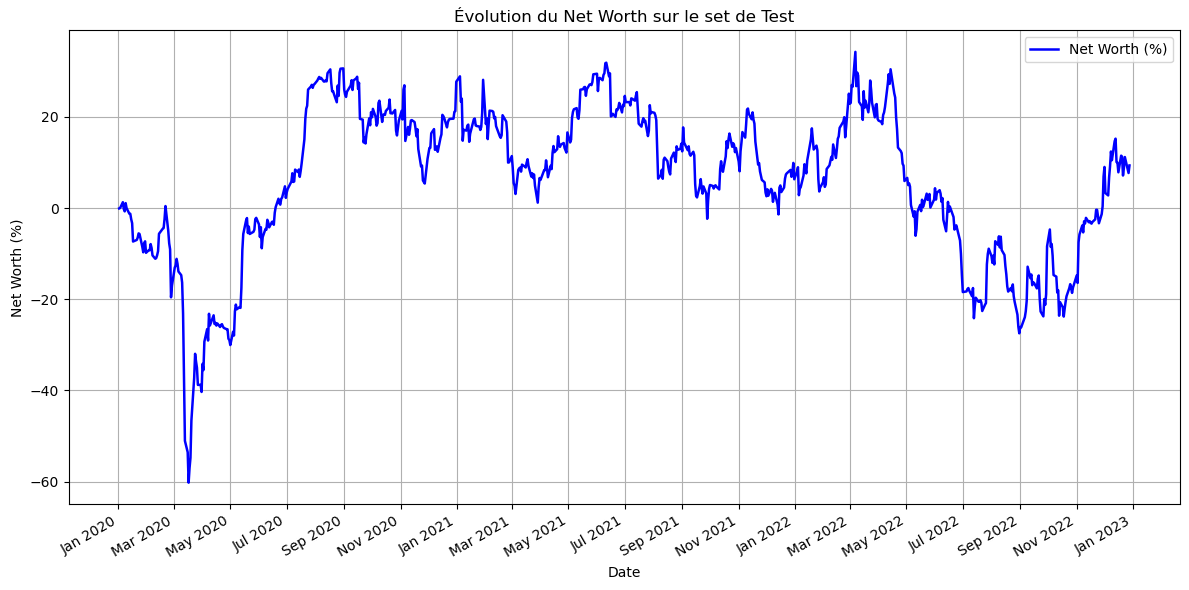

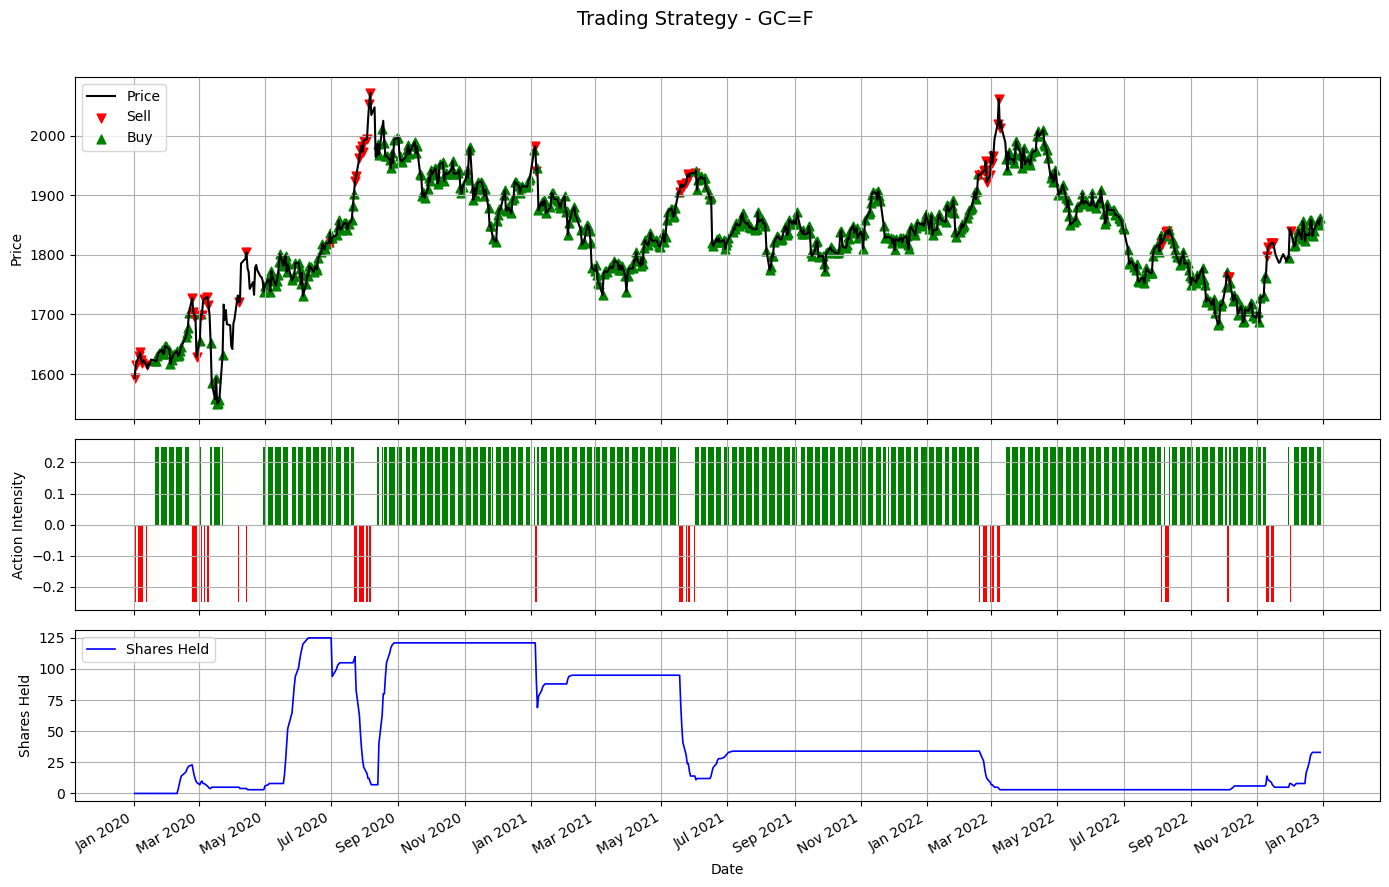

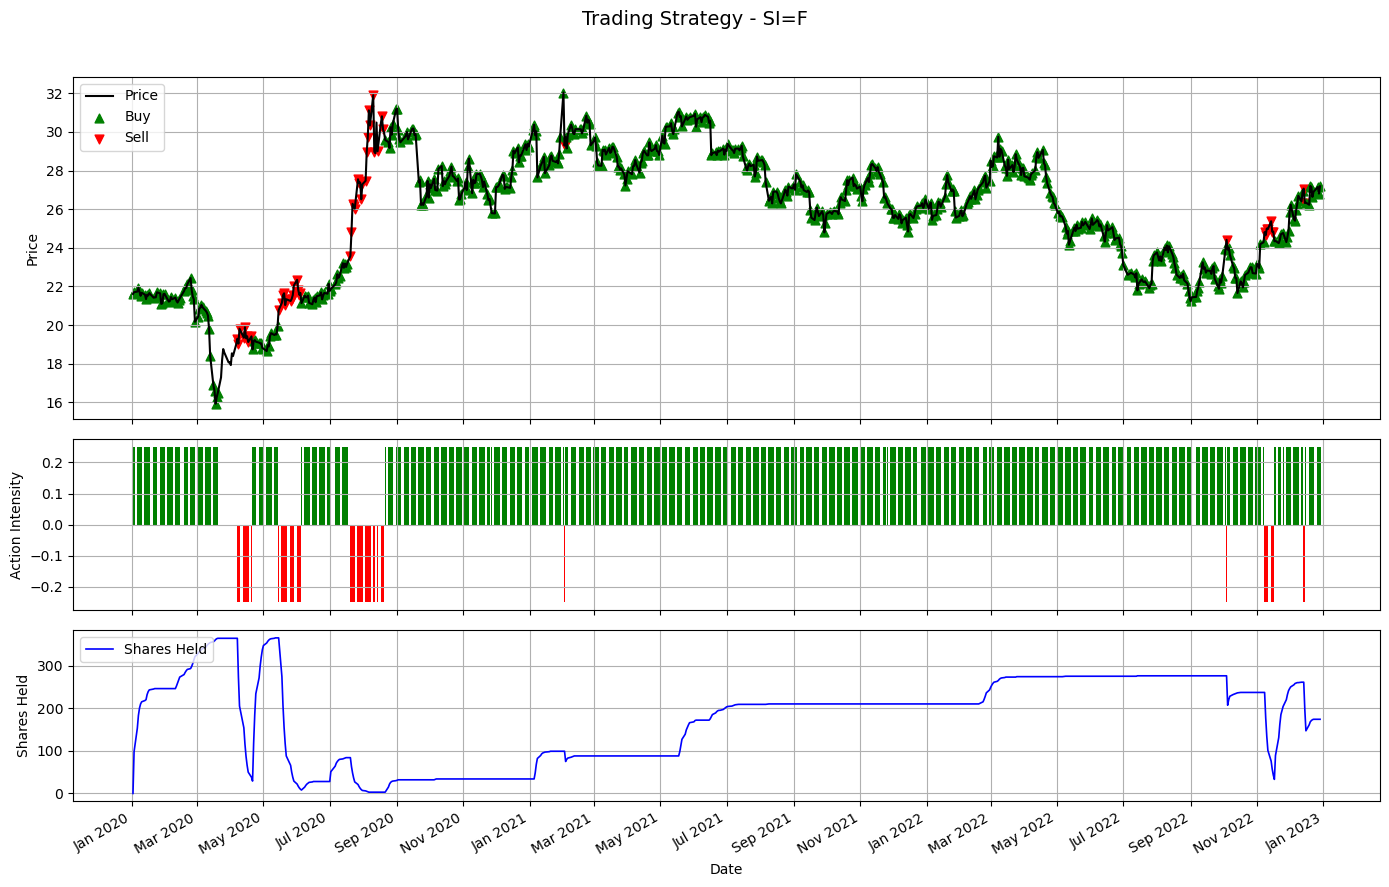

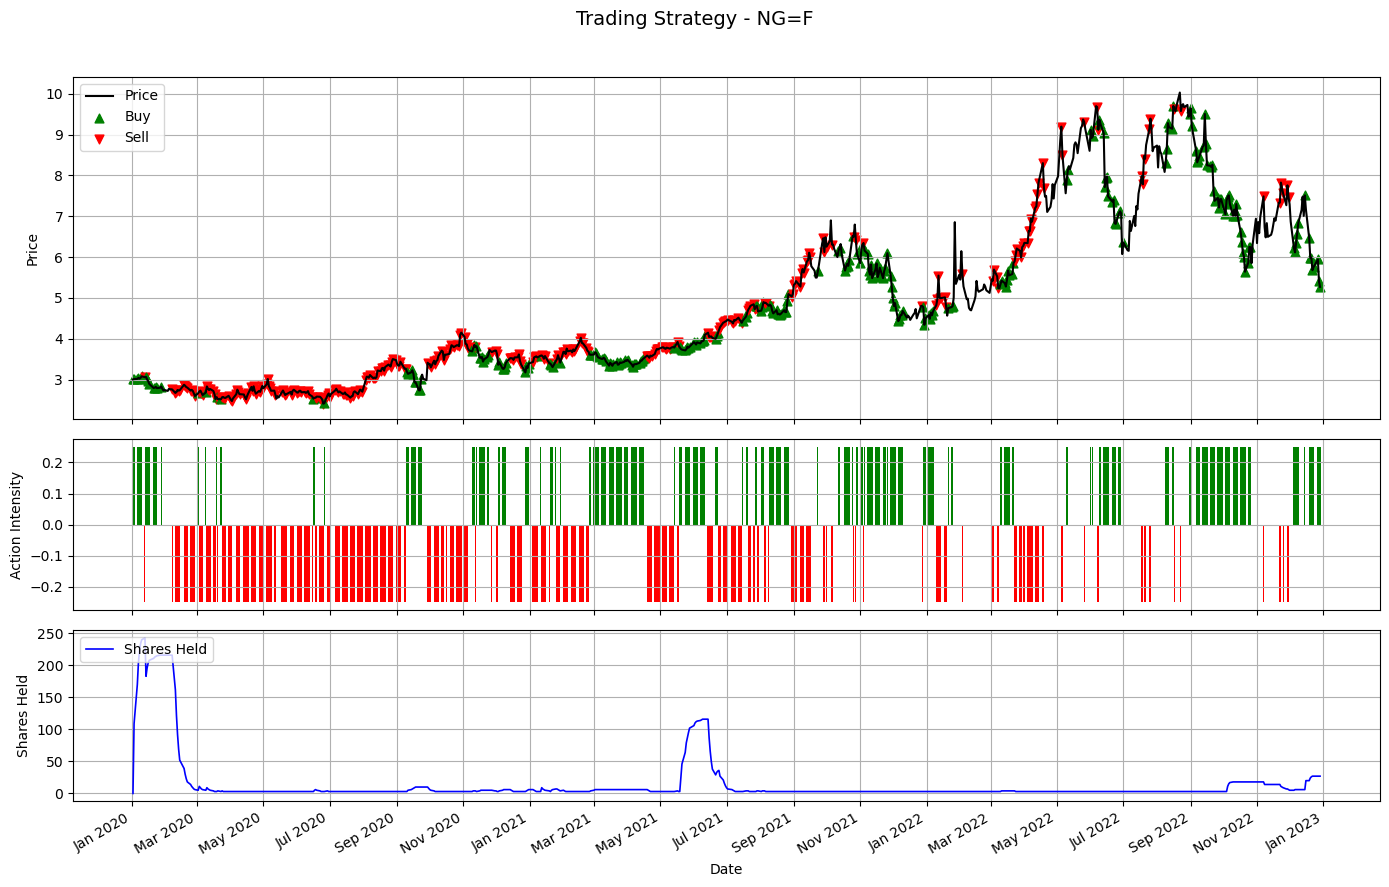

In [16]:
max_days = env_test.envs[0].max_steps - 1 
test_metrics_bollinger = get_bollinger_metrics(env_test, bollinger_model, n_tests=max_days, visualize=False)

plot_net_worth(test_metrics=test_metrics_bollinger, env=env_test)

nb_days = env_test.envs[0].max_steps
plot_trading_strategy_bollinger(env_test, bollinger_model, n_steps=nb_days)

In [24]:
metrics = compute_performance_metrics(test_metrics_bollinger['net_worths_pct'])
df_metrics = pd.DataFrame([metrics])
print(df_metrics.round(4))

     E(R)  Std(R)      DD  Sharpe  Sortino     MDD  Calmar  Perc of +Ret  \
0  0.0006  0.0299  0.1635  0.0191    0.025  0.6072  0.0009        0.5325   

   Ave. P / Ave. L  
0           0.9301  


# Benchmark

In [25]:
def plot_benchmark_net_worth(test_metrics, env):
    """Plot the Net Worth accumulated at each step for the DQN and the Bollinger agents.

    Args:
        test_metrics (list): list of the dictionnary of metrics computed for each steps
        env : trading environment
    """
    colors = ["blue", "green"]
    labels = ["DQN", "Bollinger"]

    plt.figure(figsize=(12,6))
    
    for i in range(len(test_metrics)):
        df_index = env.envs[0].commodity_data[env.envs[0].tickers[0]].index
        dates = df_index[:len(test_metrics[i]['net_worths_pct'])]

        plt.plot(dates, test_metrics[i]['net_worths_pct'], label=labels[i], color=colors[i], linewidth=1.8)
    
    plt.title("Évolution du Net Worth sur le set de Test")
    plt.xlabel("Date")
    plt.ylabel("Net Worth (%)")
    plt.grid(True)
    plt.legend()
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2))
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    plt.gcf().autofmt_xdate()
    plt.tight_layout()
    plt.show()

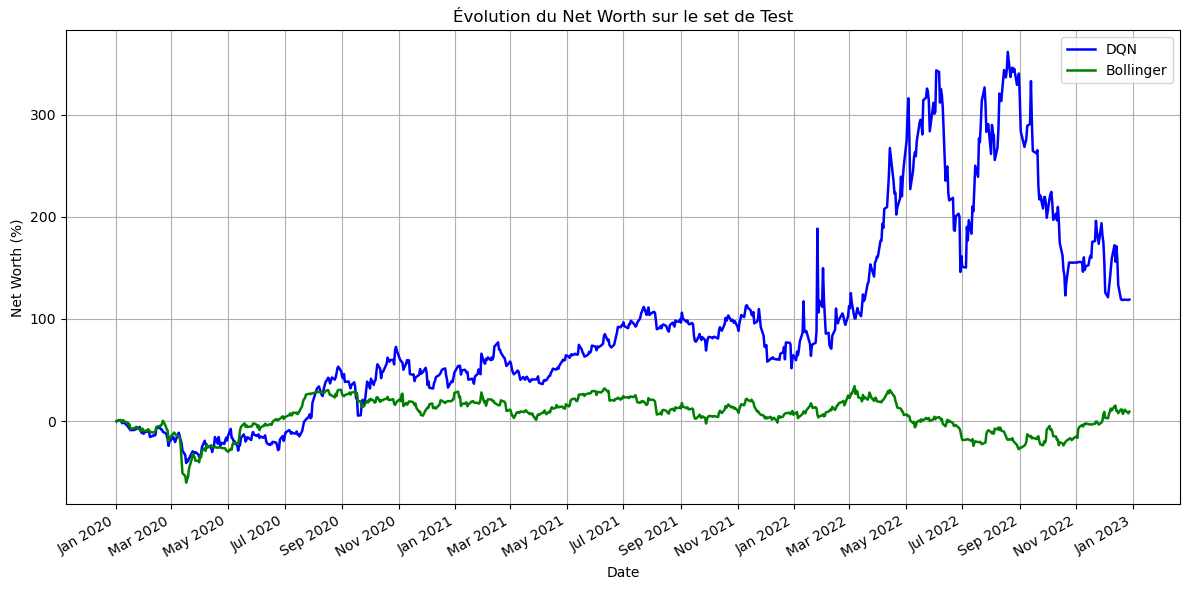

In [26]:
plot_benchmark_net_worth([test_metrics, test_metrics_bollinger], env_test)